## Data Cleaning

In [136]:
import sklearn as sk
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics

# Set a random seed
r = 16
np.random.seed(r)

# Read data
dat = pd.read_csv("data/df_training_scholarjet.csv")
dat = dat.drop(["cuid", "Unnamed: 0"], axis=1)

In [132]:
# Print the percent of rows and columns with NAs
# print(dat[dat.isna().any(axis=1)])
print(100 * sum(dat.isna().any(axis=1)) / dat.shape[0])
print(100 * sum(dat.isna().any(axis=0)) / dat.shape[1])

99.97866742515822
91.75824175824175


Nearly every row and column has at least one null entry. This means that to perform any useful analysis these missing values will need to be imputed. I chose to use the rather simpler strategy of just using the median of a column to impute missing values.

In [137]:
# Find columns that are strings and turn them into several columns with a one-hot encoding
one_hots = pd.get_dummies(dat.loc[:,(dat.dtypes == "object").values])

# Find the columns that are not strings
not_str = dat.loc[:, (dat.dtypes != "object").values]

# Concatenate these together for the full df
dat = pd.concat([not_str, one_hots])

# Separate the data matrix and the output vectors for each
X = dat.drop(["convert_30", "revenue_30"], axis=1)
y_rev = dat_imp.loc[:, "revenue_30"]
y_conv = dat_imp.loc[:, "convert_30"]

# Fit an imputer on all the data and use it to transform
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='median')

X_imp = imp.fit_transform(X)

X = pd.DataFrame(X_imp, columns=X.columns)

C:\Users\travi\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [138]:
from sklearn.model_selection import train_test_split

# Standardize the data
X = (X - np.mean(X,axis=0))/np.std(X, axis=0)

# Remove columns where NAs appeared since these do not have any information
X = X.drop(X.columns[X.isna().any()], axis=1)

# Separate the data into train and test 80/20
X_train, X_test, y_rev_train, y_rev_test, y_conv_train, y_conv_test = train_test_split(X, y_rev, y_conv, 
                                                                                         test_size=0.20, random_state=r)

# Further separate the train into train and validation 85/15
X_train, X_val, y_rev_train, y_rev_val, y_conv_train, y_conv_val = train_test_split(X_train, y_rev_train, y_conv_train, 
                                                                                         test_size=0.15, random_state=r)

## Exploratory Data Analysis

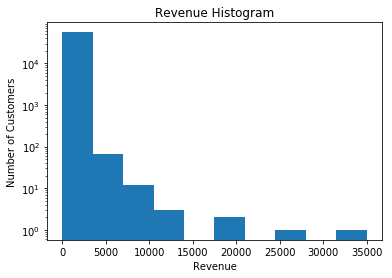

In [91]:
from matplotlib import pyplot as plt

plt.hist(y_rev)
plt.title("Revenue Histogram")
plt.yscale("log")
plt.ylabel("Number of Customers")
plt.xlabel("Revenue")
plt.show()

The vast majority of customers accounted for no revenue in the past 30 days. 

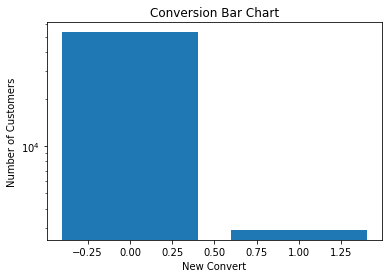

In [92]:
plt.bar([0,1], [len(y_conv) - sum(y_conv), sum(y_conv)])
plt.title("Conversion Bar Chart")
plt.yscale("log")
plt.ylabel("Number of Customers")
plt.xlabel("New Convert")
plt.show()

Similar to revenue, the vast majority of customers have not been recently converted.

In [35]:
pca = sk.decomposition.PCA(n_components=25)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=25, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [36]:
print(pca.explained_variance_ratio_) 
print(sum(pca.explained_variance_ratio_))

[0.09443123 0.04294762 0.03290221 0.0266817  0.02456999 0.02058239
 0.01926358 0.01671258 0.01562178 0.01391739 0.01308399 0.01251763
 0.01160724 0.01042734 0.01007352 0.00974711 0.00931341 0.00878997
 0.00872676 0.00822017 0.00799731 0.00752537 0.00732049 0.00711735
 0.00697956]
0.44707768197055925


Text(0.5, 1.0, 'Scree Plot')

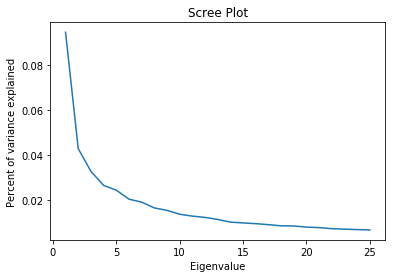

In [75]:
plt.plot([i for i in range(1, 26)], pca.explained_variance_ratio_)
plt.xlabel("Eigenvalue")
plt.ylabel("Percent of variance explained")
plt.title("Scree Plot")

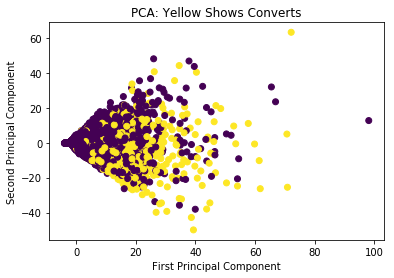

In [81]:
X_train_pc = pca.transform(X_train)

plt.scatter(X_train_pc[:,0], X_train_pc[:,1], c=y_conv_train)
plt.ylabel("Second Principal Component")
plt.xlabel("First Principal Component")
plt.title("PCA: Yellow Shows Converts")
plt.show()

The first 25 principal components only account for about 45% of the overall variance in the data. Because of how little variance the first two principal components explain and the lack of clear boundary between the conversions and not, PCA is relatively uninformative for this problem.

## Classifier Model

### Logistic Regression

In [41]:
# Hyperparameter sweep for logisitc regression
cs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]

# Note: smaller C implies stronger regularization
log_r_auc = []
log_r_models = []
log_r_auc_val = []

for c in tqdm(cs):
    log_r = LogisticRegression(penalty="l2", C=c, random_state=r, solver="lbfgs", max_iter=10000)
    log_r.fit(X_train, y_conv_train)
    
    y_conv_pred = log_r.predict_proba(X_train)
    fpr, tpr, thresholds = metrics.roc_curve(y_conv_train, y_conv_pred[:,1])
    log_r_auc.append(metrics.auc(fpr, tpr))
    log_r_models.append(log_r)
    
    y_conv_val_pred = log_r.predict_proba(X_val)
    fpr, tpr, thresholds = metrics.roc_curve(y_conv_val, y_conv_val_pred[:,1])
    log_r_auc_val.append(metrics.auc(fpr, tpr))
    log_r_models.append(log_r)
    
print(log_r_auc)
print(log_r_auc_val)

100%|██████████| 7/7 [00:35<00:00,  8.87s/it]


[0.8966150577616122, 0.896479399939694, 0.9002171213974755, 0.9014924994150061, 0.9014805597978639, 0.9015609090991971, 0.9024590141239323]
[0.9035449078126323, 0.9013726929628898, 0.8994343582648634, 0.8965906203235734, 0.8961214482687223, 0.896741677725386, 0.8977162567881715]


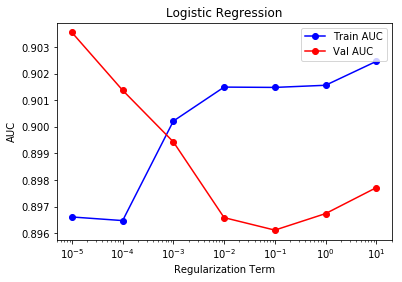

In [82]:
lr_df = pd.DataFrame({"C":cs, "Train AUC": log_r_auc, "Val AUC": log_r_auc_val})

plt.plot('C', 'Train AUC', data=lr_df, marker='o', color='blue')
plt.plot('C', 'Val AUC', data=lr_df, marker='o', color='red')
plt.xscale('log')
plt.xlabel("Regularization Term")
plt.ylabel("AUC")
plt.title("Logistic Regression")
plt.legend()
plt.show()

## Random Forest

In [43]:
# Perform a parameter sweep for a Random Forest Classifer
from sklearn.ensemble import RandomForestClassifier

rf_models = []
rf_auc = []
rf_auc_val = []
n_trees = [50, 100, 150, 200]

for n in tqdm(n_trees):
    for d in range(1, 6):
        rfc = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=r)
        rfc.fit(X_train, y_conv_train)

        # Calculate training accuracy
        y_conv_pred = rfc.predict_proba(X_train)
        fpr, tpr, thresholds = metrics.roc_curve(y_conv_train, y_conv_pred[:,1])
        rf_auc.append(metrics.auc(fpr, tpr))

        y_conv_val_pred = rfc.predict_proba(X_val)
        fpr, tpr, thresholds = metrics.roc_curve(y_conv_val, y_conv_val_pred[:,1])
        rf_auc_val.append(metrics.auc(fpr, tpr))
        rf_models.append(rfc)
print(rf_auc)
print(rf_auc_val)

100%|██████████| 4/4 [00:42<00:00, 10.51s/it]


[0.8944390625374591, 0.8974611565693724, 0.9033936808495766, 0.9062954872906894, 0.9109472715307326, 0.8944315530045054, 0.8988212667001849, 0.9028745168523848, 0.9065650673680066, 0.9112905017576832, 0.8948654041151834, 0.899423325946483, 0.9032678016281235, 0.906843527873232, 0.9116586309486627, 0.8959449805153957, 0.9007288231339537, 0.9032160655382333, 0.9069006124793985, 0.9115975079425803]
[0.897661669066644, 0.900374820001694, 0.9025324467534424, 0.9033620860038966, 0.9051531279705605, 0.8970477924913647, 0.901125871756501, 0.9020053928904198, 0.9036922005439948, 0.904757366989487, 0.8973513190464089, 0.9015331620408278, 0.9024108008395215, 0.9043517237484825, 0.9054639485746017, 0.8973146135095199, 0.901069872283555, 0.902254802307743, 0.9041684313559402, 0.9051938334698026]


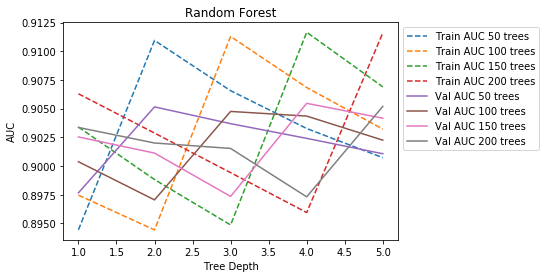

In [74]:
n_trees = [50, 100, 150, 200]
rf_auc_trees = np.array(rf_auc).reshape(-1,4)
rf_auc_val_trees = np.array(rf_auc_val).reshape(-1,4)
rf_auc_cols = ["Train AUC {} trees".format(n) for n in n_trees]
rf_auc_val_cols = ["Val AUC {} trees".format(n) for n in n_trees]

# Dictionary comprehension
rf_train_df = pd.DataFrame({"Train AUC {} trees".format(n): rf_auc_trees[:,i] for i,n in enumerate(n_trees)})
rf_val_df = pd.DataFrame({"Val AUC {} trees".format(n): rf_auc_val_trees[:,i] for i,n in enumerate(n_trees)})

rf_df = pd.concat([rf_train_df, rf_val_df, pd.DataFrame({"D":range(1,6)})], axis=1)

for col in rf_df.columns:
    if col == "D":
        pass
    elif "Train" in col:
        plt.plot("D", col, data=rf_df, linestyle='dashed')
    else:
        plt.plot("D", col, data=rf_df)
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel("AUC")
plt.title("Random Forest")
plt.xlabel("Tree Depth")
plt.show()

## AdaBoost

In [46]:
# Perform a hyperparameter sweep for an AdaBoost Classifier
from sklearn.ensemble import AdaBoostClassifier

lrs = [1e-2, 1e-1, 1, 5, 10]
n_trees = [10, 25, 50, 75, 100]
abc_auc_val = []
abc_auc = []
abc_models = []

for lr in tqdm(lrs):
    for n in n_trees:
        abc = AdaBoostClassifier(n_estimators=n, learning_rate=lr, random_state=r)
        abc.fit(X_train, y_conv_train)

        # Calculate training accuracy
        y_conv_pred = abc.predict_proba(X_train)
        fpr, tpr, thresholds = metrics.roc_curve(y_conv_train, y_conv_pred[:,1])
        abc_auc.append(metrics.auc(fpr, tpr))

        # Calculate validation accuracy
        y_conv_val_pred = abc.predict_proba(X_val)
        fpr, tpr, thresholds = metrics.roc_curve(y_conv_val, y_conv_val_pred[:,1])
        abc_auc_val.append(metrics.auc(fpr, tpr))
        abc_models.append(rfc)
print(abc_auc)
print(abc_auc_val)

100%|██████████| 5/5 [01:38<00:00, 17.51s/it]


[0.823712559119845, 0.84385337636908, 0.866123315040102, 0.8720964394211311, 0.8829825339203644, 0.8728140995533111, 0.8966003696013836, 0.9030156312414128, 0.9046894534619992, 0.9057155649589795, 0.8872302350544594, 0.9054718630563731, 0.9113941832859542, 0.9146984723300385, 0.9178193518368136, 0.7889224461763342, 0.7889224461763342, 0.7889224461763342, 0.7889224461763342, 0.7889224461763342, 0.7883806522826244, 0.7883806522826244, 0.7883806522826244, 0.7883806522826244, 0.7883806522826244]
[0.835022964489746, 0.8521025684464146, 0.8714393276298577, 0.8766442198191076, 0.8889252807032404, 0.8772413906692643, 0.8998357662516118, 0.9050053646553915, 0.906030766769254, 0.90655358537802, 0.8960694487581293, 0.9039164337276826, 0.904291959605086, 0.9017251602337861, 0.9006136412833761, 0.8019270406866759, 0.8019270406866759, 0.8019270406866759, 0.8019270406866759, 0.8019270406866759, 0.8043244298877187, 0.8043244298877187, 0.8043244298877187, 0.8043244298877187, 0.8043244298877187]


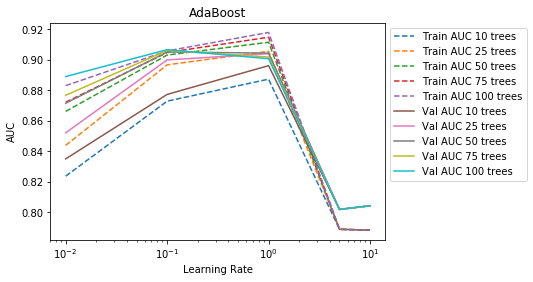

In [84]:
n_trees = [10, 25, 50, 75, 100]
abc_auc_trees = np.array(abc_auc).reshape(-1,5)
abc_auc_val_trees = np.array(abc_auc_val).reshape(-1,5)
abc_auc_cols = ["Train AUC {} trees".format(n) for n in n_trees]
abc_auc_val_cols = ["Val AUC {} trees".format(n) for n in n_trees]

# Dictionary comprehension
abc_train_df = pd.DataFrame({"Train AUC {} trees".format(n): abc_auc_trees[:,i] for i,n in enumerate(n_trees)})
abc_val_df = pd.DataFrame({"Val AUC {} trees".format(n): abc_auc_val_trees[:,i] for i,n in enumerate(n_trees)})

abc_df = pd.concat([abc_train_df, abc_val_df, pd.DataFrame({"LR":lrs})], axis=1)

for col in abc_df.columns:
    if col == "LR":
        pass
    elif "Train" in col:
        plt.plot("LR", col, data=abc_df, linestyle='dashed')
    else:
        plt.plot("LR", col, data=abc_df)
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel("AUC")
plt.xlabel("Learning Rate")
plt.xscale("log")
plt.title("AdaBoost")
plt.show()

## Application to test data

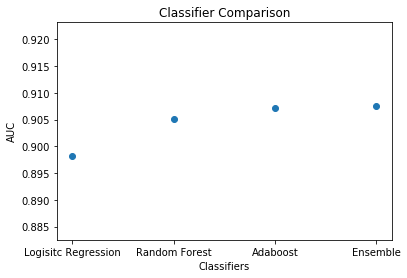

In [85]:
aucs = []

# Logisitc regression
log_r = LogisticRegression(penalty="l2", C=1e-5, random_state=r, solver="lbfgs", max_iter=10000)
log_r.fit(X_train, y_conv_train)

y_conv_pred_lr = log_r.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_conv_test, y_conv_pred_lr[:,1])
aucs.append(metrics.auc(fpr, tpr))

# Random Forest
rf = RandomForestClassifier(n_estimators=50, max_depth=2, random_state=r)
rf.fit(X_train, y_conv_train)

y_conv_pred_rf = rfc.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_conv_test, y_conv_pred_rf[:,1])
aucs.append(metrics.auc(fpr, tpr))

# Random Forest
ab = AdaBoostClassifier(n_estimators=75, learning_rate=1e-1, random_state=r)
ab.fit(X_train, y_conv_train)

y_conv_pred_ab = ab.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_conv_test, y_conv_pred_ab[:,1])
aucs.append(metrics.auc(fpr, tpr))

# Average the probabilities to get an ensemble
y_conv_pred_ens = (y_conv_pred_lr[:,1] + y_conv_pred_rf[:,1] + y_conv_pred_ab[:,1]) / 3
fpr, tpr, thresholds = metrics.roc_curve(y_conv_test, y_conv_pred_ens)
aucs.append(metrics.auc(fpr, tpr))

plt.scatter(["Logisitc Regression", "Random Forest", "Adaboost", "Ensemble"], aucs)
plt.ylabel("AUC")
plt.xlabel("Classifiers")
plt.title("Classifier Comparison")
plt.show()

The best classifier is an ensembling of logistic regression, random forest, adaboost. Each of these is equally weighted. This classifier performs about as equally well as the Adaboost model, but because it is derived from three separately trained models it is likely to generalize better on the heldout data set.

### Ensemble Model

In [50]:
class Ensemble:
    def __init__(self, log_reg, random_forest, adaboost):
        self.log_reg = log_reg
        self.random_forest = random_forest
        self.adaboost = adaboost
        
    def predict(self, data):
        # Average the votes of the three classifiers
        a = self.log_reg.predict_proba(data)
        b = self.random_forest.predict_proba(data)
        c = self.adaboost.predict_proba(data)
        
        pred = (a[:,1] + b[:,1] + c[:,1]) / 3
        return pred

ens = Ensemble(log_r, rf, ab)

## Regression Modeling

### Ridge Regression

In [73]:
# Perform a hyperparameter sweep for ridge regression

import sklearn.linear_model as lm

lm_mses = []
lm_mses_val = []
alphas = [0, 1e-1, 1, 1e2, 1e3, 1e4, 1e5, 1e6]

pred_conv = np.where(ens.predict(X_val) > 0.5, 1, 0)

for a in alphas:
    reg = lm.Ridge(alpha=a)
    reg.fit(pd.concat([X_train, y_conv_train], axis=1), y_rev_train)

    rev_train_pred = reg.predict(pd.concat([X_train, y_conv_train], axis=1))
    
    # Multiply the predicted value by the conversion to 0 out non converts
    lm_mses.append(metrics.mean_squared_error(y_rev_train, rev_train_pred))
    
    # Add the predicted class as a predictor in the validation data
    X_val.loc[:,"conv_30"] = pred_conv
    
    rev_val_pred = reg.predict(X_val)
    lm_mses_val.append(metrics.mean_squared_error(y_rev_val, rev_val_pred))
    
    # Remove the convert column from the validation data
    X_val = X_val.drop("conv_30", axis=1)
    
print(lm_mses)
print(lm_mses_val)
print(min(lm_mses_val))

[85000.13309108859, 84949.52594420915, 84951.77902408948, 85051.42400681869, 87776.21659775543, 99082.10408310119, 106761.3639229964, 112618.5823860921]
[260125.49685440457, 260412.5263769889, 260391.2269414669, 259493.00950080258, 254315.75246418596, 247142.77749431512, 247182.1476033572, 254859.8875149034]
247142.77749431512


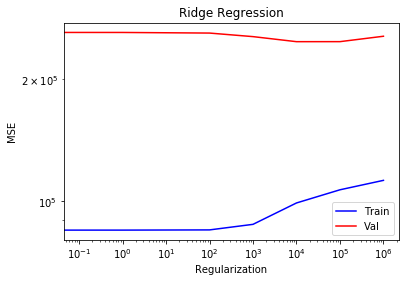

In [94]:
plt.plot(alphas, lm_mses, color="blue")
plt.plot(alphas, lm_mses_val, color="red")
plt.xscale("log")
plt.yscale("log")
plt.ylabel("MSE")
plt.xlabel("Regularization")
plt.legend(["Train", "Val"])
plt.title("Ridge Regression")
plt.show()

### AdaBoost

In [69]:
from sklearn.ensemble import AdaBoostRegressor

abr_mses = []
abr_mses_val = []
lrs = [1e-2, 1e-1, 1, 5, 10]
n_trees = [10, 25, 50, 75, 100]

for n in tqdm(n_trees):
    for lr in lrs:
        
        abr = AdaBoostRegressor(n_estimators=n, learning_rate=lr, loss="square", random_state=r)

        abr.fit(pd.concat([X_train, y_conv_train], axis=1), y_rev_train)

        rev_train_pred = abr.predict(pd.concat([X_train, y_conv_train], axis=1))

        # Multiply the predicted value by the conversion to 0 out non converts
        abr_mses.append(metrics.mean_squared_error(y_rev_train, rev_train_pred))

        # Add the predicted class as a predictor in the validation data
        X_val.loc[:,"conv_30"] = pred_conv
        rev_val_pred = reg.predict(X_val)
        abr_mses_val.append(metrics.mean_squared_error(y_rev_val, rev_val_pred))
        
        # Remove the convert column from the validation data
    X_val = X_val.drop("conv_30", axis=1)
    
print(abr_mses)
print(abr_mses_val)

100%|██████████| 5/5 [06:15<00:00, 83.07s/it]


[85456.37612170998, 76420.57691561428, 57219.86903822434, 88305.98343052469, 2173933.825316961, 73043.70144841015, 65633.9160197823, 175784.48758685996, 115381.22759497869, 2173933.825316961, 73332.2876084941, 75389.4330212594, 343026.7116687794, 24924347.33890817, 600476397.4667253, 73171.37245696815, 81797.42809407093, 445190.6266329088, 114419.20929371094, 600476397.4667253, 70077.52278420933, 58651.62277931273, 619576.2256197558, 101548.54849161956, 600476397.4667253]
[254859.8875149034, 254859.8875149034, 254859.8875149034, 254859.8875149034, 254859.8875149034, 254859.8875149034, 254859.8875149034, 254859.8875149034, 254859.8875149034, 254859.8875149034, 254859.8875149034, 254859.8875149034, 254859.8875149034, 254859.8875149034, 254859.8875149034, 254859.8875149034, 254859.8875149034, 254859.8875149034, 254859.8875149034, 254859.8875149034, 254859.8875149034, 254859.8875149034, 254859.8875149034, 254859.8875149034, 254859.8875149034]


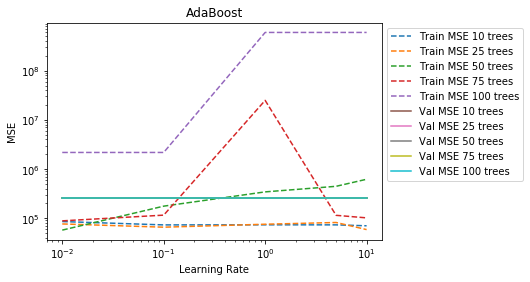

In [90]:
n_trees = [10, 25, 50, 75, 100]
ab_mse_trees = np.array(abr_mses).reshape(-1,5)
ab_mse_val_trees = np.array(abr_mses_val).reshape(-1,5)
ab_mse_cols = ["Train MSE {} trees".format(n) for n in n_trees]
ab_mse_val_cols = ["Val MSE {} trees".format(n) for n in n_trees]

ab_train_df = pd.DataFrame({"Train MSE {} trees".format(n): ab_mse_trees[:,i] for i,n in enumerate(n_trees)})
ab_val_df = pd.DataFrame({"Val MSE {} trees".format(n): ab_mse_val_trees[:,i] for i,n in enumerate(n_trees)})

ab_df = pd.concat([ab_train_df, ab_val_df, pd.DataFrame({"LR":lrs})], axis=1)

for col in ab_df.columns:
    if col == "LR":
        pass
    elif "Train" in col:
        plt.plot("LR", col, data=ab_df, linestyle='dashed')
    else:
        plt.plot("LR", col, data=ab_df)
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel("MSE")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Learning Rate")
plt.title("AdaBoost")
plt.show()

In [88]:
min(abr_mses_val)

254859.8875149034

The minimum MSE after the parameter sweep for the AdaBoost Regressor is greater than that of the Ridge Regression model. The Ridge regression model is therefore the more desirable model

In [109]:
rreg = lm.Ridge(alpha=1e5)
rreg.fit(pd.concat([X_train, y_conv_train], axis=1), y_rev_train)

Ridge(alpha=100000.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

## Predictions On Held Out Data

In [126]:
# Read in data
heldout_dat = pd.read_csv("data/df_holdout_scholarjet.csv")
cuid = heldout_dat.loc[:,"cuid"]
heldout_dat = heldout_dat.drop(["cuid", "Unnamed: 0"], axis=1)

# Format the data
# Find columns that are strings and turn them into several columns with a one-hot encoding
one_hots_heldout = pd.get_dummies(heldout_dat.loc[:,(heldout_dat.dtypes == "object").values])

# Find the columns that are not strings
not_str_heldout = heldout_dat.loc[:, (heldout_dat.dtypes != "object").values]

# Concatenate these together for the full df
heldout_dat = pd.concat([not_str_heldout, one_hots_heldout], axis=1)

# Use the imputer fit to the training data
heldout_dat_imp = imp.transform(heldout_dat)
heldout_dat_imp = pd.DataFrame(heldout_dat_imp, columns=heldout_dat.columns)

print(heldout_dat_imp.shape)


(30375, 225)


In [127]:
# Standardize
X_heldout = (heldout_dat_imp - np.mean(X,axis=0))/np.std(X, axis=0)

X_heldout = X_heldout.drop(X_heldout.columns[X_heldout.isna().any()], axis=1)

In [128]:
print(X_val.columns.difference(X_heldout.columns))

# Heldout data is missing values for 'currentstatus_Unconfirmed' replace with median of training data
X_heldout.loc[:,"currentstatus_Unconfirmed"] = np.median(X.loc[:,"currentstatus_Unconfirmed"])

Index(['currentstatus_Unconfirmed'], dtype='object')


In [129]:
# Predict
conv_heldout = ens.predict(X_heldout)
X_heldout.loc[:,"conv_30"] = conv_heldout
rev_heldout = rreg.predict(X_heldout)

In [141]:
sub_df = pd.DataFrame({"CuID": cuid, "pred_convert_30": conv_heldout, "pred_revenue_30": rev_heldout})
sub_df.to_csv("submission.csv", index=False)